In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from rm.regret_matching import RegretMatching, InternalRegretMatching
from rm.utils import p_outcomes
from rm.equilibrium import is_epsilon_nash, is_epsilon_coarse_correlated

First, define a payoff matrix.  The payoff matrix is a [N x K_1 x K_2 ... K_N] dimensional numpy array where N is the number of players and K_i is the number of actions for player i

In [2]:
# We populate the values with a modified version of the shapley game (http://www.eecs.harvard.edu/cs286r/courses/spring06/papers/greenwaldgondek_nr01.pdf)
NUM_ACTIONS = 3
NUM_PLAYERS = 2
num_actions = [NUM_ACTIONS for i in range(NUM_PLAYERS)]
payoffs =  np.zeros([NUM_PLAYERS] + num_actions)

payoffs[0] = np.array([[1, 0, 0], 
                       [0, 1, 0],
                       [0, 0, 1]])

payoffs[1] = np.array([[0, 1, 0], 
                       [0, 0, 2],
                       [1, 0, 0]])


In [3]:
# builds a list of regret matching players. We set blue_print to false to use the default random initialization
players = [RegretMatching(i, num, payoffs[i], blue_print=None) for i, num in enumerate(num_actions)]
ITERATIONS = 100000

emprical_dist = np.zeros(num_actions) # will approach a CCE
for itr in tqdm(range(ITERATIONS)):
    s = [players[i].strategy for i in range(NUM_PLAYERS)] # get the strategies at this itation
    for i in range(NUM_PLAYERS): 
        players[i].update(s) # update cumulative regrets
    emprical_dist += p_outcomes(s)

    # print(p_outcomes(s))
emprical_dist /= ITERATIONS

100%|██████████| 10000/10000 [00:02<00:00, 4534.31it/s]


In [4]:
# we see that the empirical distribution of play converges to a CCE
is_epsilon_coarse_correlated(emprical_dist, payoffs, num_actions, 0.001)

(True, array([0.00063146, 0.00078364]))

Now let's look at the convergence over time

In [20]:
# the expected utility at each iteration
expected_utility1 = np.zeros(ITERATIONS)
expected_utility2 = np.zeros(ITERATIONS)

empirical_dist_itr = np.zeros(num_actions+[ITERATIONS])
empirical_dist = np.zeros(num_actions)

max_deviation_payoff = np.zeros((NUM_PLAYERS, ITERATIONS))
players = [RegretMatching(i, num, payoffs[i], blue_print=None) for i, num in enumerate(num_actions)]


for itr in tqdm(range(ITERATIONS)):

    a = [players[i].get_action() for i in range(NUM_PLAYERS)]
    s = [players[i].strategy for i in range(NUM_PLAYERS)]
    for i in range(NUM_PLAYERS): 
        players[i].update(s)

    empirical_dist  += p_outcomes(s)
    empirical_dist_itr [:,:, itr] =  empirical_dist/(itr+1)     

    _, max_deviation_payoff[:, itr] = is_epsilon_coarse_correlated(empirical_dist/(itr+1), payoffs, num_actions, 0.01)
    expected_utility1[itr] = np.dot(payoffs[0].flatten(), empirical_dist.flatten()/(itr+1))
    expected_utility2[itr] = np.dot(payoffs[1].flatten(),empirical_dist.flatten()/(itr+1))

avg_strats = [players[i].get_average_strategy() for i in range(NUM_PLAYERS)] 
epsilon_nash, diff = is_epsilon_nash(avg_strats, players, 0.01)
print("converged to {}-CCE, {}-Nash".format(np.max(max_deviation_payoff[:, -1]), np.max(diff) ))

 10%|█         | 10000/100000 [00:03<00:27, 3224.86it/s]


IndexError: index 10000 is out of bounds for axis 2 with size 10000

Let's visualize the empirical distribution over time

In [12]:
def plot_outcomes(outcomes):
    '''
    Plots frequency of outcomes over iterations

    parameters:
        outcomes : (np.array) array of dimension (|A_1|,|A_2|,...,|A_N|,iterations) where |A_i| is the number 
            of actions for player i
    '''

    num_outcomes  = np.product(outcomes.shape[:-1])
    iterations = outcomes.shape[-1]

    reshaped = outcomes.reshape(num_outcomes, iterations)
    for i in range(0, num_outcomes):
        plt.plot(reshaped [i, :], label=f'{i}')

    # plt.legend()
    plt.xscale('log')
    plt.xlabel('Iteration')
    plt.ylabel('Prob.')
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

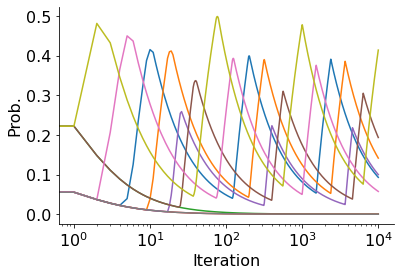

In [17]:
import matplotlib
font = {'size'   : 16}

matplotlib.rc('font', **font)
plot_outcomes(empirical_dist_itr)
plt.savefig('figures/shapley_outcomes.pdf', bbox_inches = 'tight')

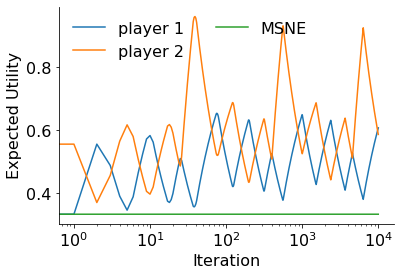

<Figure size 432x288 with 0 Axes>

In [18]:
plt.plot(expected_utility1, label='player 1')
plt.plot(expected_utility2, label='player 2')
plt.plot(np.ones_like(expected_utility1)*(1/3), label='MSNE')

plt.xlabel('Iteration')
plt.ylabel('Expected Utility')
plt.legend(ncol = 2, frameon=False)
plt.xscale('log')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.show()
plt.savefig('figures/shapley_util.pdf', bbox_inches = 'tight')

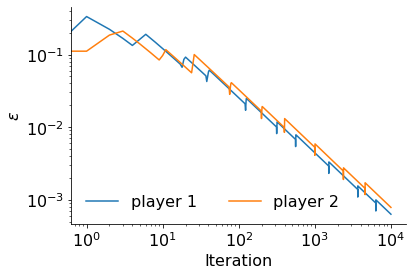

In [19]:
plt.plot(max_deviation_payoff[0, :], label='player 1')
plt.plot(max_deviation_payoff[1, :], label='player 2')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$\epsilon$')
plt.legend(ncol = 2, frameon=False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.savefig('figures/shapley_deviations.pdf', bbox_inches = 'tight')